In [11]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("cleanedData.csv")
df.head()

,score,sentiment_score,change
0,70,0.8,-2.047424
1,70,-0.8,-2.047424
2,113,0.6,-2.047424
3,83,-0.7,-2.047424
4,73,-0.6,6.510162


# Gradient-Boosting Regression Trees (GBRT)

## 1. The Loss function

We use squared-error loss:

$$
L(y, F(x)) = \frac{1}{2}(y - F(x))^2
$$

Our goal is to find a function $F(x)$ that minimizes:

$$
\mathcal{L} = \sum_{i=1}^{n} L(y_i, F(x_i)) = \sum_{i=1}^n \frac{1}{2}(y_i - F(x_i))^2
$$

---

## 2. Initialize with a Constant Model

We start with a constant prediction that minimizes the loss:

$$
F_0(x) = \gamma_0 = \frac{1}{n} \sum_{i=1}^n y_i
$$

So, the first prediction is the mean of all targets.

In [5]:
F0 = df["change"].mean()
df["F0"] = F0

# Compute residuals for first tree
df["res1"] = df["change"] - df["F0"]
df.head()

,score,sentiment_score,change,F0,res1
0,70,0.8,-2.047424,-0.393665,-1.653759
1,70,-0.8,-2.047424,-0.393665,-1.653759
2,113,0.6,-2.047424,-0.393665,-1.653759
3,83,-0.7,-2.047424,-0.393665,-1.653759
4,73,-0.6,6.510162,-0.393665,6.903828


## 3. Iterate and Add Trees (for $m = 1, 2, ..., M$)

### a) Compute Pseudo-Residuals

For squared-error loss, the residuals are just:

$$
r_i^{(m)} = y_i - F_{m-1}(x_i)
$$

This is how far off our model is at iteration $m$.

### b) Fit a Regression Tree

We fit a small regression tree $h_m(x)$ to the residuals $\{(x_i, r_i^{(m)})\}$. The tree splits the feature space into $J_m$ leaf regions $R_{jm}$.

### c) Compute Optimal Leaf Values

In each region $R_{jm}$, set the leaf value to the average residual:

$$
\gamma_{jm} = \frac{1}{|R_{jm}|} \sum_{x_i \in R_{jm}} r_i^{(m)}
$$

### d) Update the Model

Add the new tree (scaled by a learning rate $\nu$) to the model:

$$
F_m(x) = F_{m-1}(x) + \nu \sum_{j=1}^{J_m} \gamma_{jm} \cdot \mathbf{1}_{\{x \in R_{jm}\}}
$$

---

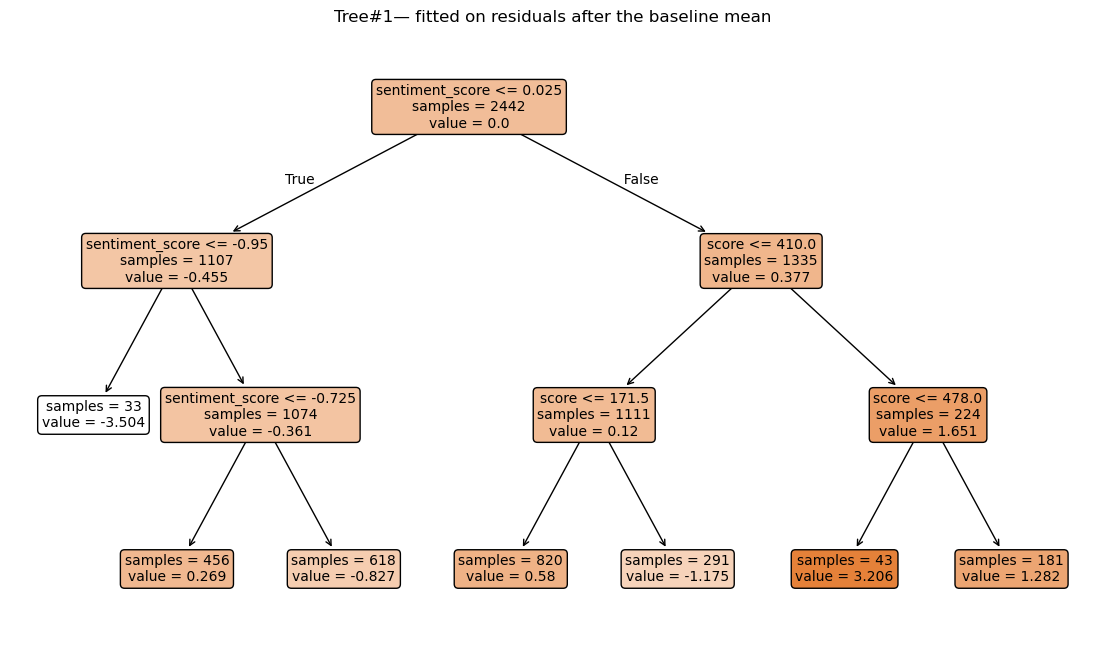

In [12]:
X      = df[["score", "sentiment_score"]]
y_res  = df["res1"]                   

# fit a small regression tree to those residuals
first_tree = DecisionTreeRegressor(
    max_depth=3,          
    min_samples_leaf=30,  
    random_state=42
)

first_tree.fit(X, y_res)

plt.figure(figsize=(14, 8))
plot_tree(
    first_tree,
    feature_names=["score", "sentiment_score"],
    filled=True,
    rounded=True,
    impurity=False,
    fontsize=10
)
plt.title("Tree#1— fitted on residuals after the baseline mean")
plt.show()


In [14]:
# learning‑rate
nu = 0.1   # I can try 0.05 or 0.2 later     

# 1) predictions from Tree #1  
df["h1"] = first_tree.predict(X)

# 2) update the ensemble prediction
df["F1"] = df["F0"] + nu * df["h1"]

# 3) compute residuals for Tree #2
df["res2"] = df["change"] - df["F1"]

df.head()

,score,sentiment_score,change,F0,res1,leaf1,h1,F1,res2,leaf2,h2,F2,y_pred
0,70,0.8,-2.047424,-0.393665,-1.653759,B,0.580029,-0.335662,-1.711762,C,0.448365,-0.324492,-0.324492
1,70,-0.8,-2.047424,-0.393665,-1.653759,B,0.269277,-0.366738,-1.680687,D,-0.288450,-0.398174,-0.398174
2,113,0.6,-2.047424,-0.393665,-1.653759,B,0.580029,-0.335662,-1.711762,C,0.448365,-0.324492,-0.324492
3,83,-0.7,-2.047424,-0.393665,-1.653759,B,-0.826567,-0.476322,-1.571102,D,-0.288450,-0.398174,-0.398174
4,73,-0.6,6.510162,-0.393665,6.903828,B,-0.826567,-0.476322,6.986484,D,-0.288450,-0.398174,-0.398174


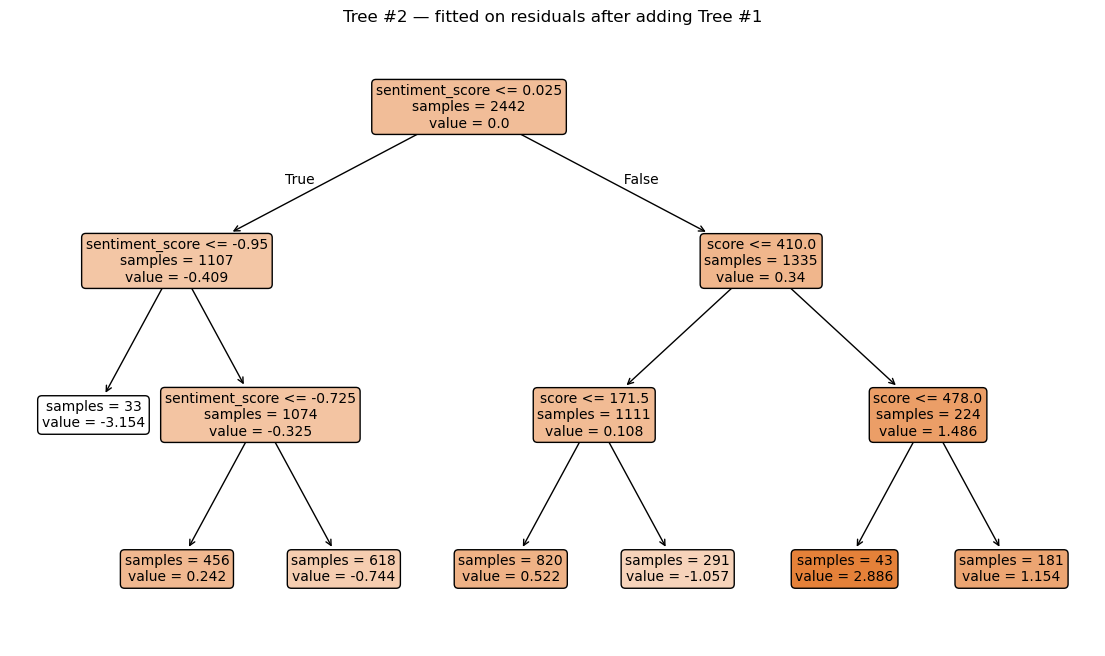

In [ ]:
# 4) fit Tree #2 on the new residuals
second_tree = DecisionTreeRegressor(
    max_depth=3,
    min_samples_leaf=30,
    random_state=43
)
second_tree.fit(X, df["res2"])

plt.figure(figsize=(14, 8))
plot_tree(
    second_tree,
    feature_names=["score", "sentiment_score"],
    filled=True,
    rounded=True,
    impurity=False,
    fontsize=10
)
plt.title("Tree #2 — fitted on residuals after adding Tree #1")
plt.show()



## 4. Final Prediction

After $M$ iterations, the final model is:

$$
F_M(x) = \gamma_0 + \nu \sum_{m=1}^M h_m(x)
$$

---

## 5. Why It Works

- Each new tree learns from the mistakes of the current model
- The procedure performs **gradient descent in function space**
- Regularization is controlled via:
  - Learning rate $\nu$
  - Tree depth (shallow trees reduce overfitting)
  - Subsampling (if used)

---

## Key Hyperparameters

- $M$: number of boosting rounds (trees)
- $\nu$: learning rate
- Tree depth / number of leaves
- Subsample fraction (optional)

---

## Algorithm Summary

1. Initialize $F_0(x) = \bar{y}$
2. For $m = 1$ to $M$:
   - Compute residuals: $r_i = y_i - F_{m-1}(x_i)$
   - Fit regression tree $h_m(x)$ to $(x_i, r_i)$
   - Compute leaf values: $\gamma_{jm} = \text{avg residual in } R_{jm}$
   - Update: $F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)$
3. Return $F_M(x)$ for predictions



In [10]:
# actual vs predicted
df[["score", "sentiment_score", "change", "y_pred"]].tail(10)

,score,sentiment_score,change,y_pred
2432,233,-0.6,-0.079987,-0.446926
2433,232,0.2,-0.079987,-0.446926
2434,62,0.2,-0.079987,-0.398174
2435,139,0.2,-0.079987,-0.446926
2436,66,0.2,-0.079987,-0.398174
2437,76,0.2,-0.079987,-0.398174
2438,289,0.0,-0.079987,-0.446926
2439,212,0.2,-0.079987,-0.446926
2440,143,-1.0,-0.079987,-0.446926
2441,69,0.2,-0.079987,-0.398174


In [9]:
# evaluate
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(df["change"], df["y_pred"])
print(f"MSE after 2 trees: {mse:.4f}")

MSE after 2 trees: 70.1081
